In [2]:
pip install psycopg2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.9/384.9 kB 1.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for psycopg2: filename=psycopg2-2.9.9-cp311-cp311-macosx_10_9_x86_64.whl size=133312 sha256=20b677fee3e5bafb214ed5d7379e6b301ed62c774479b6ed361e1380498763d8
  Stored in directory: /Users/handecavsi/Library/Caches/pip/wheels/ab/34/b9/78ebef1b3220b4840ee482461e738566c3c9165d2b5c914f51
Successfully built psycopg2
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2 as ps

In [4]:
conn = ps.connect(dbname="Capstone",
                  user="postgres",
                  password="1234",
                  port = "5432")

CASE 1: Sipariş Analizi

Tüm yıl-ay bazlı sipariş sayılarının görselleştirilmesi.
Hangi yılın hangi ayında kaç sipariş olduğunu gösterir. 
Bu şekilde o yıllarla ilgili çeşitli analizler yapabiliriz.

In [7]:
sql = """SELECT TO_CHAR(order_date, 'YYYY-MM') AS year_and_month,
                COUNT(order_id) AS order_count
         FROM orders
         GROUP BY TO_CHAR(order_date, 'YYYY-MM')
         ORDER BY year_and_month ASC;"""

In [8]:
df = sqlio.read_sql_query(sql,conn)
df.head()

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1600180838.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = sqlio.read_sql_query(sql,conn)


year_and_month  order_count
0        1996-07           22
1        1996-08           25
2        1996-09           23
3        1996-10           26
4        1996-11           25

In [10]:
print(len(df))

23


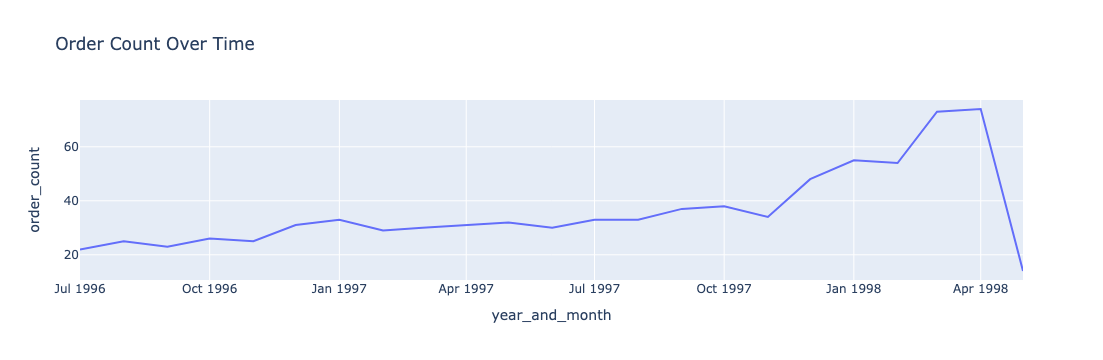

In [9]:
import plotly.express as px
import pandas as pd

# Çizgi grafiğini oluştur
fig = px.line(df, x='year_and_month', y='order_count', title='Order Count Over Time')

# Grafiği göster
fig.show()


Siparişlerin teslim edilmesi gereken tarih ile siparişin verildiği tarihler baz alınarak
sipariş teslim edilme süreleri kategorilendirilmiştir. 
Sipariş verildiği andan itabaren kargonun en geç hareket etmesi gereken süreler genel olarak
3 kategoride ele alınmıştır. 14,28 ve 42. Bu gün sayıları Emergency,priority,standatd olarak kategorize edilmiştir.

In [11]:
sql = """WITH required_delivery_time_day AS
(
SELECT 
	order_id,
    order_date, 
    required_date,
    required_date - order_date AS required_delivery_time
FROM orders
)select 
	required_delivery_time,
	count(order_id) as order_count,
	CASE
		WHEN required_delivery_time = '14' THEN 'Emergency'
		WHEN required_delivery_time = '28' THEN 'Priority'
		WHEN required_delivery_time = '42' THEN 'Standard'
	END as order_priority_level
from required_delivery_time_day
group by(required_delivery_time)
order by required_delivery_time ASC"""

In [12]:
df = sqlio.read_sql_query(sql,conn)
df.head()

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1600180838.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



required_delivery_time  order_count order_priority_level
0                      14           68            Emergency
1                      28          701             Priority
2                      42           61             Standard

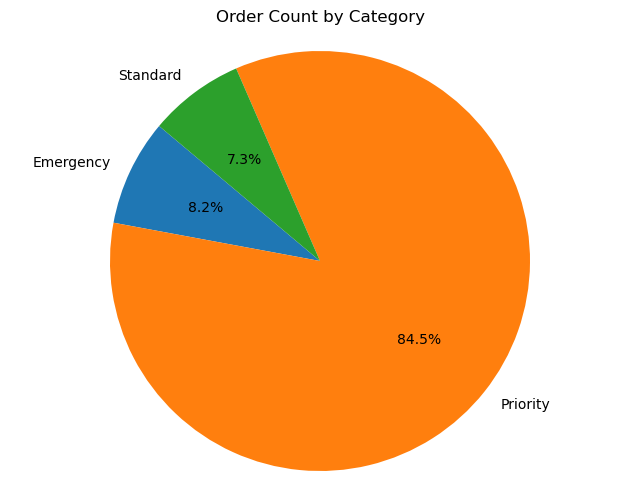

In [15]:
import pandas as pd
import matplotlib.pyplot as plt


# Pasta grafiğini çiz
plt.figure(figsize=(8, 6))
plt.pie(df['order_count'], labels=df['order_priority_level'], autopct='%1.1f%%', startangle=140)
plt.title('Order Count by Category')
plt.axis('equal')  # Dairesel pasta grafiği yapmak için
plt.show()

Bütün yıllarda haftanın günleri bazlı sipariş sayıları incelenmiştir.
3 yılda da hafta sonu sipariş sayısı gözlemlenmemiştir. 
Hafta içi yapılan siparişlerden en çok salı ve perşembe en az cuma günü sipariş 
verildiği gözlemlenmiştir. 

In [16]:
sql = """
Select 
	TO_CHAR(order_date, 'Dy') AS day_of_week,
    COUNT(order_id) AS order_count
from orders
Group by day_of_week
ORDER BY order_count DESC
"""

In [17]:
df = sqlio.read_sql_query(sql,conn)
df.head()

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1600180838.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



day_of_week  order_count
0         Tue          168
1         Thu          168
2         Wed          165
3         Mon          165
4         Fri          164

In [19]:
# Bar grafiğini çiz

colors = ['skyblue', 'salmon', 'lightgreen', 'gold', 'lightcoral']

plt.figure(figsize=(8, 6))
plt.bar(df['day_of_week'], df['order_count'], color=colors)
plt.title('Order Count by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Order Count')
plt.show()

In [20]:
sql = """
WITH mountly_order_count AS (
select 
	TO_CHAR(order_date,'MM') AS month_of_year,
	count(order_id) as order_count
from orders
group by (month_of_year)
) SELECT 
    SUM(order_count) as sum_order,
    CASE
        WHEN month_of_year IN ('12','01','02') THEN 'Winter'
        WHEN month_of_year IN ('03','04','05') THEN 'Spring'
        WHEN month_of_year IN ('06','07','08') THEN 'Summer'
        WHEN month_of_year IN ('09','10','11') THEN 'Autumn'
    END AS season_name
FROM mountly_order_count
GROUP BY season_name
ORDER BY sum_order
"""

In [21]:
df = sqlio.read_sql_query(sql,conn)
df.head()

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1600180838.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



sum_order season_name
0      143.0      Summer
1      183.0      Autumn
2      250.0      Winter
3      254.0      Spring

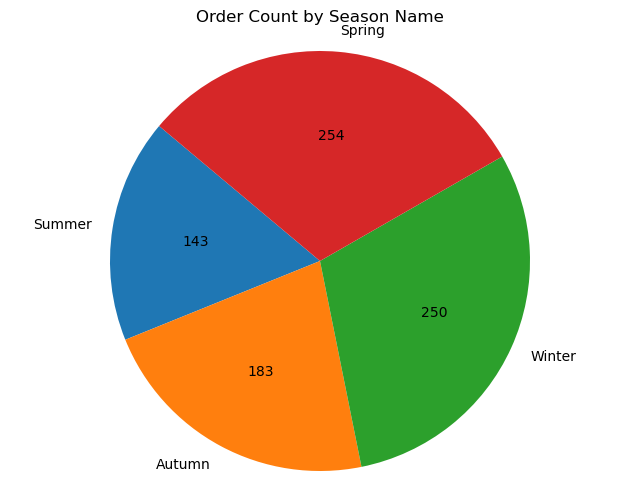

In [28]:
import matplotlib.pyplot as plt

# Pasta grafiğini çiz
plt.figure(figsize=(8, 6))
_, _, autopcts = plt.pie(df['sum_order'], labels=df['season_name'], startangle=140, autopct='%1.1f%%')
plt.title('Order Count by Season Name')
plt.axis('equal')  # Dairesel pasta grafiği yapmak için

# Dilimlerin üstüne tam sayı değerlerini yaz
for i, autopct in enumerate(autopcts):
    autopct.set_text(f"{df.iloc[i]['sum_order']:.0f}")

plt.show()




In [50]:
sql = """
Select
	o.order_id,
	ROUND(AVG(od.product_id)::numeric, 2) as avg_product
FROM orders o join order_details od 
ON o.order_id = od.order_id
GROUP BY 1
ORDER BY avg_product desc
"""

In [51]:
df = sqlio.read_sql_query(sql,conn)
df.head()

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1600180838.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



order_id  avg_product
0     10602         77.0
1     11050         76.0
2     10732         76.0
3     10959         75.0
4     10955         75.0

In [52]:
print(len(df))

830


In [53]:
print(min(df['avg_product']))
print(max(df['avg_product']))

1.0
77.0


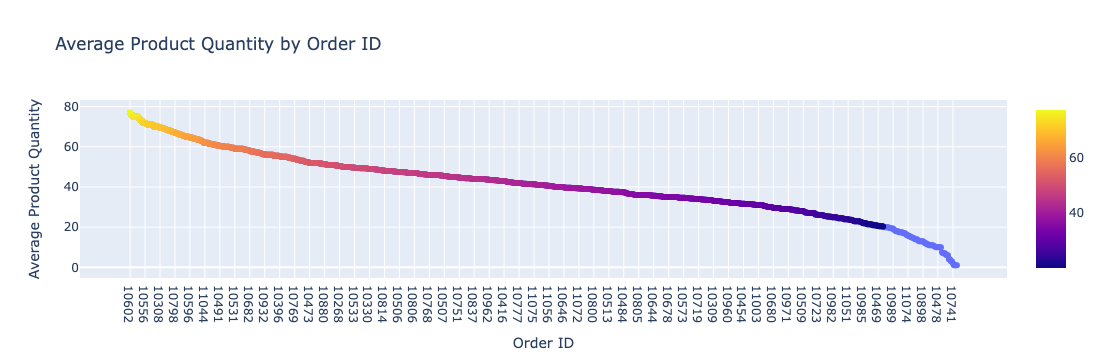

In [57]:
import pandas as pd
import plotly.express as px

# Renk paletini oluştur
colors = ['blue', 'orange', 'red']

# Scatter plot çiz
fig = px.scatter(df, x='order_id', y='avg_product', title='Average Product Quantity by Order ID')
fig.update_layout(xaxis_title='Order ID', yaxis_title='Average Product Quantity')

# 'order_id' sütununu string olarak kullan
df['order_id'] = df['order_id'].astype(str)

for i, threshold in enumerate([20, 50, 77]):
    scatter_df = df[df['avg_product'] > threshold]
    fig.add_trace(px.scatter(scatter_df, x='order_id', y='avg_product', color=scatter_df['avg_product'], color_continuous_scale=[(0, colors[i]), (1, colors[i])]).update_traces(mode='markers').data[0])

fig.show()



In [58]:
sql = """
Select 
	count(order_id) as order_count,
	CASE 
		WHEN shipped_date = required_date THEN 'delayed'
		WHEN shipped_date > required_date THEN 'delayed'
		WHEN shipped_date IS NULL THEN 'waiting'
		ELSE 'left on time'
	END as deliver_status
from orders
group by (deliver_status)
"""

In [59]:
df = sqlio.read_sql_query(sql,conn)
df.head()

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1600180838.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



order_count deliver_status
0           21        waiting
1          769   left on time
2           40        delayed

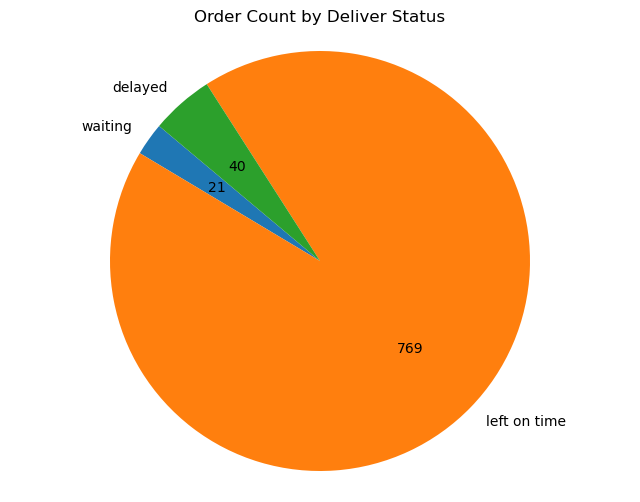

In [61]:
import matplotlib.pyplot as plt

# Pasta grafiğini çiz
plt.figure(figsize=(8, 6))
_, _, autopcts = plt.pie(df['order_count'], labels=df['deliver_status'], startangle=140, autopct='%1.1f%%')
plt.title('Order Count by Deliver Status')
plt.axis('equal')  # Dairesel pasta grafiği yapmak için

# Dilimlerin üstüne tam sayı değerlerini yaz
for i, autopct in enumerate(autopcts):
    autopct.set_text(f"{df.iloc[i]['order_count']:.0f}")

plt.show()

CASE 2: Müşteri Analizi

In [62]:
#En çok müşteri sayısına sahip 10 ülke
sql= """
select 
	count(customer_id) as customer_count,
	country
from customers
group by country
order by customer_count desc
limit 10
"""

In [63]:
df = sqlio.read_sql_query(sql,conn)
df.head()

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1600180838.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



customer_count  country
0              13      USA
1              11   France
2              11  Germany
3               9   Brazil
4               7       UK

In [65]:
import pandas as pd
import plotly.express as px

# Çubuk grafik çiz
fig = px.bar(df, x=df['country'], y=df['customer_count'], title='Customer Count by Country', labels={'country': 'Country', 'customer_count': 'Customer Count'}, color='country')
fig.update_layout(xaxis_title='', yaxis_title='Customer Count')
fig.show()

In [66]:
#En çok müşteri sayısına sahip 10 bölge
sql= """
select 
	count(customer_id) as customer_count,
	region
from customers
group by region
order by customer_count desc
limit 10
"""

In [67]:
df = sqlio.read_sql_query(sql,conn)
df.head()

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1600180838.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



customer_count region
0              60   None
1               6     SP
2               4     OR
3               3     RJ
4               3     WA

In [68]:
import pandas as pd
import plotly.express as px

# Çubuk grafik çiz
fig = px.bar(df, x=df['region'], y=df['customer_count'], title='Customer Count by Region', labels={'region': 'Region', 'customer_count': 'Customer Count'}, color='region')
fig.update_layout(xaxis_title='', yaxis_title='Customer Count')
fig.show()

In [69]:
#Sipariş tutarı en fazla olan ilk 10 müşteri discount değeri hesaba katılmıştır.

sql = """
SELECT 
    c.customer_id,
    c.company_name,
    ROUND(SUM(CASE WHEN od.discount = 0 THEN od.unit_price * od.quantity ELSE (od.unit_price * od.quantity) * (1 - od.discount / 100) END)::NUMERIC, 2) AS total_order_amount
FROM 
    order_details od 
JOIN 
    orders o ON od.order_id = o.order_id
JOIN 
    customers c ON c.customer_id = o.customer_id
GROUP BY 
    c.customer_id, c.company_name
ORDER BY 
    total_order_amount DESC
LIMIT 10;
"""

In [70]:
df = sqlio.read_sql_query(sql,conn)
df.head()

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1600180838.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



customer_id                  company_name  total_order_amount
0       QUICK                    QUICK-Stop           117411.33
1       SAVEA            Save-a-lot Markets           115560.28
2       ERNSH                  Ernst Handel           113153.06
3       HUNGO  Hungry Owl All-Night Grocers            57244.02
4       RATTC    Rattlesnake Canyon Grocery            52234.42

In [71]:
import pandas as pd
import plotly.express as px

# Çubuk grafik çiz
fig = px.bar(df, x=df['company_name'], y=df['total_order_amount'], title='Total Order Amount', labels={'customer': 'Customer Company', 'total_order_amount': 'Total Order Amount'}, color='company_name')
fig.update_layout(xaxis_title='', yaxis_title='Total Order Amount')
fig.show()

In [72]:
#Ürün kategorilerine göre müşteri sayıları

sql = """
SELECT 
    ct.category_name,
    ct.description,
    COUNT(c.customer_id) AS customer_count
FROM 
    customers c 
JOIN 
    orders o ON c.customer_id = o.customer_id
JOIN 
    order_details od ON od.order_id = o.order_id
JOIN 
    products p ON p.product_id = od.product_id
JOIN 
    categories ct ON ct.category_id = p.category_id
GROUP BY 
    ct.category_name, ct.description
ORDER BY 
    customer_count DESC;
"""

In [73]:
df = sqlio.read_sql_query(sql,conn)
df.head()

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1600180838.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



category_name                                        description  \
0       Beverages        Soft drinks, coffees, teas, beers, and ales   
1  Dairy Products                                            Cheeses   
2     Confections                Desserts, candies, and sweet breads   
3         Seafood                                   Seaweed and fish   
4      Condiments  Sweet and savory sauces, relishes, spreads, an...   

   customer_count  
0             404  
1             366  
2             334  
3             330  
4             216

In [78]:
import pandas as pd
import plotly.express as px

# Yatay çubuk grafik çiz
fig = px.bar(df, x='customer_count', y='category_name', orientation='h', title='Customer Count by Category', color='category_name')
fig.update_layout(xaxis_title='Customer Count', yaxis_title='Category')
fig.show()

CASE 3: Ürün Analizi

In [120]:
#En çok sipariş edilen ilk 10 ürünü getir (Satışı devam eden ürünler baz alınmıştır)

sql = """
select 
	count(o.order_id) as order_count,
	p.product_name
from orders o JOIN order_details od
ON o.order_id=od.order_id
JOIN products p ON p.product_id = od.product_id
WHERE p.discontinued = 0
GROUP BY p.product_name
ORDER BY order_count DESC 
LIMIT 10
"""

In [121]:
df = sqlio.read_sql_query(sql,conn)
df.head()

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1600180838.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



order_count            product_name
0           54    Raclette Courdavault
1           51       Camembert Pierrot
2           51       Gorgonzola Telino
3           50  Gnocchi di nonna Alice
4           48          Tarte au sucre

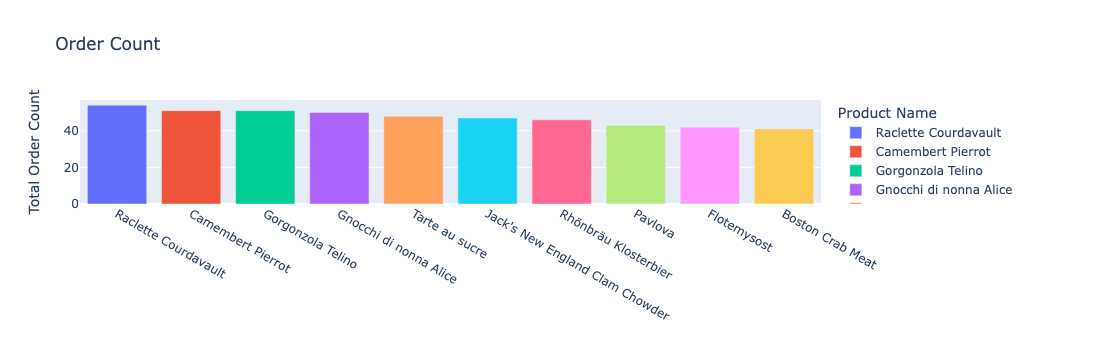

In [122]:
import pandas as pd
import plotly.express as px

# Çubuk grafik çiz
fig = px.bar(df, x=df['product_name'], y=df['order_count'], title='Order Count', labels={'product_name': 'Product Name', 'order_count': 'Order Count'}, color='product_name')
fig.update_layout(xaxis_title='', yaxis_title='Total Order Count')
fig.show()

In [82]:
#Her bir ürün kategorisinde kaç ürün var?

sql = """
select 
	c.category_id,
	c.category_name,
	count(product_id) as product_count
from products p JOIN categories c
ON p.category_id = c.category_id
GROUP BY c.category_id, c.category_name
ORDER BY product_count DESC
"""

In [83]:
df = sqlio.read_sql_query(sql,conn)
df.head()

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1600180838.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



category_id   category_name  product_count
0            3     Confections             13
1            1       Beverages             12
2            8         Seafood             12
3            2      Condiments             12
4            4  Dairy Products             10

In [84]:
import pandas as pd
import plotly.express as px

# Yatay çubuk grafik çiz
fig = px.bar(df, x='product_count', y='category_name', orientation='h', title='Customer Count by Category', color='category_name')
fig.update_layout(xaxis_title='Product Count', yaxis_title='Category')
fig.show()

In [90]:
#Satışı devam eden ve satışı durudurulan ürün sayısı

sql = """
Select 
	count(product_id) as product_count,
	CASE
		WHEN discontinued = 1 THEN 'sale stopped'
		WHEN discontinued = 0 THEN 'sale continued'
	END as satis_var_yok
from products
Group by satis_var_yok
"""

In [91]:
df = sqlio.read_sql_query(sql,conn)
df.head()

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1600180838.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



product_count   satis_var_yok
0             67  sale continued
1             10    sale stopped

In [92]:
import matplotlib.pyplot as plt

# Pasta grafiğini çiz
plt.figure(figsize=(8, 6))
_, _, autopcts = plt.pie(df['product_count'], labels=df['satis_var_yok'], startangle=140, autopct='%1.1f%%')
plt.title('Product Count by Sale Status')
plt.axis('equal')  # Dairesel pasta grafiği yapmak için

# Dilimlerin üstüne tam sayı değerlerini yaz
for i, autopct in enumerate(autopcts):
    autopct.set_text(f"{df.iloc[i]['product_count']:.0f}")

plt.show()

In [123]:
#En çok sipariş edilen 10 ürünün yıllık olarak ortalama sipariş sayısı

sql = """
WITH most_sold_10_product AS(
select 
	count(o.order_id) as order_count,
	p.product_name,
	p.product_id
from orders o JOIN order_details od
ON o.order_id=od.order_id
JOIN products p ON p.product_id = od.product_id
WHERE p.discontinued = 0
GROUP BY p.product_name, p.product_id
ORDER BY order_count DESC 
LIMIT 10
), average_orders AS (
    SELECT 
        p.product_id,
        TO_CHAR(o.order_date, 'YYYY') AS order_year,
        ROUND(AVG(COUNT(o.order_id)) OVER(PARTITION BY TO_CHAR(o.order_date, 'YYYY'), p.product_id)::Numeric,2) AS avg_order_count
    FROM 
        orders o
    JOIN 
        order_details od ON o.order_id = od.order_id
    JOIN 
        products p ON p.product_id = od.product_id
    WHERE 
        p.product_id IN (SELECT product_id FROM most_sold_10_product)
    GROUP BY 
        TO_CHAR(o.order_date, 'YYYY'), p.product_id
)
SELECT 
    asp.product_id,
    asp.product_name,
    asp.order_count,
    ao.order_year,
    ao.avg_order_count
FROM 
    most_sold_10_product asp
JOIN 
    average_orders ao ON asp.product_id = ao.product_id
ORDER BY 
    asp.order_count DESC, ao.order_year;
"""

In [124]:
df = sqlio.read_sql_query(sql,conn)
df.head()

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1600180838.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



product_id          product_name  order_count order_year  avg_order_count
0          59  Raclette Courdavault           54       1996             10.0
1          59  Raclette Courdavault           54       1997             31.0
2          59  Raclette Courdavault           54       1998             13.0
3          31     Gorgonzola Telino           51       1996             13.0
4          60     Camembert Pierrot           51       1996             11.0

In [125]:
# order_year sütunu değeri 1996 olanları filtrele
df_1996 = df[df['order_year'] == '1996']
df_1996.head()

product_id            product_name  order_count order_year  \
0           59    Raclette Courdavault           54       1996   
3           31       Gorgonzola Telino           51       1996   
4           60       Camembert Pierrot           51       1996   
9           56  Gnocchi di nonna Alice           50       1996   
12          62          Tarte au sucre           48       1996   

    avg_order_count  
0              10.0  
3              13.0  
4              11.0  
9               7.0  
12             11.0

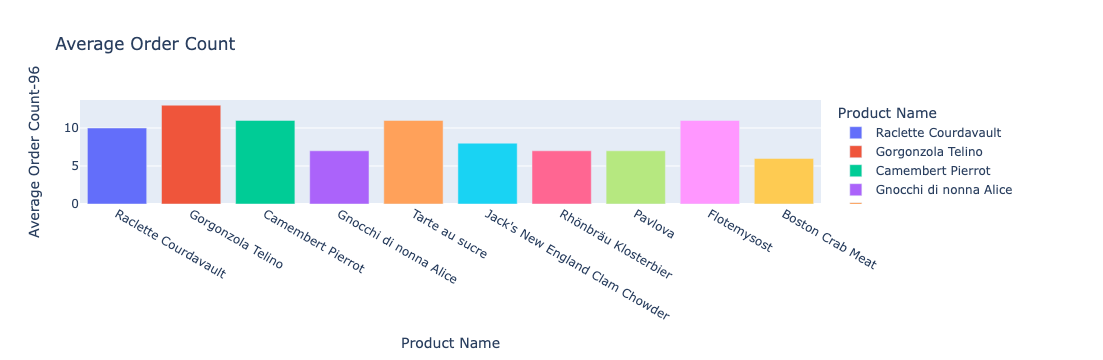

In [126]:
#96 yılında en çok satılan ürünlerin ortalama sipariş sayıları
import pandas as pd
import plotly.express as px

# Çubuk grafik çiz
fig = px.bar(df_1996, x=df_1996['product_name'], y=df_1996['avg_order_count'], title='Average Order Count', labels={'product_name': 'Product Name', 'avg_order_count': 'Average Order Count'}, color='product_name')
fig.update_layout(xaxis_title='Product Name', yaxis_title='Average Order Count-96')
fig.show()

In [127]:
# order_year sütunu değeri 1997 olanları filtrele
df_1997 = df[df['order_year'] == '1997']
df_1997.head()

product_id            product_name  order_count order_year  \
1           59    Raclette Courdavault           54       1997   
5           60       Camembert Pierrot           51       1997   
6           31       Gorgonzola Telino           51       1997   
10          56  Gnocchi di nonna Alice           50       1997   
13          62          Tarte au sucre           48       1997   

    avg_order_count  
1              31.0  
5              21.0  
6              26.0  
10             33.0  
13             22.0

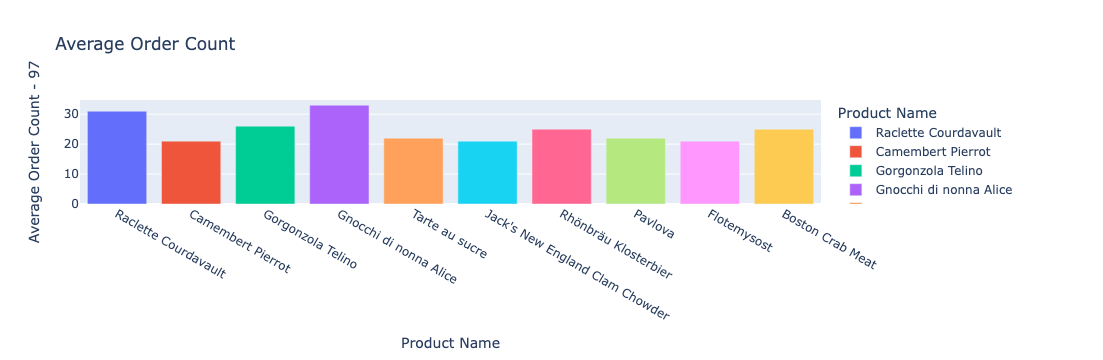

In [128]:
#97 yılında en çok satılan ürünlerin ortalama sipariş sayıları
import pandas as pd
import plotly.express as px

# Çubuk grafik çiz
fig = px.bar(df_1997, x=df_1997['product_name'], y=df_1997['avg_order_count'], title='Average Order Count', labels={'product_name': 'Product Name', 'avg_order_count': 'Average Order Count'}, color='product_name')
fig.update_layout(xaxis_title='Product Name', yaxis_title='Average Order Count - 97')
fig.show()

In [129]:
# order_year sütunu değeri 1998 olanları filtrele
df_1998 = df[df['order_year'] == '1998']
df_1998.head()

product_id            product_name  order_count order_year  \
2           59    Raclette Courdavault           54       1998   
7           31       Gorgonzola Telino           51       1998   
8           60       Camembert Pierrot           51       1998   
11          56  Gnocchi di nonna Alice           50       1998   
14          62          Tarte au sucre           48       1998   

    avg_order_count  
2              13.0  
7              12.0  
8              19.0  
11             10.0  
14             15.0

In [130]:
#98 yılında en çok satılan ürünlerin ortalama sipariş sayıları
import pandas as pd
import plotly.express as px

# Çubuk grafik çiz
fig = px.bar(df_1998, x=df_1998['product_name'], y=df_1998['avg_order_count'], title='Average Order Count', labels={'product_name': 'Product Name', 'avg_order_count': 'Average Order Count'}, color='product_name')
fig.update_layout(xaxis_title='Product Name', yaxis_title='Average Order Count-98')
fig.show()

In [131]:
#En çok sipariş edilen ilk 10 ürünün stok sayısı
sql = """
WITH most_sold_10_product AS(
select 
	count(o.order_id) as order_count,
	p.product_name,
	p.product_id
from orders o JOIN order_details od
ON o.order_id=od.order_id
JOIN products p ON p.product_id = od.product_id
WHERE p.discontinued = 0
GROUP BY p.product_name, p.product_id
ORDER BY order_count DESC 
LIMIT 10
)select 
	product_id,
	product_name,
	unit_in_stock
 from products
 WHERE product_id IN (SELECT product_id from most_sold_10_product)
 group by product_id, product_name
"""

In [132]:
df = sqlio.read_sql_query(sql,conn)
df.head()

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1600180838.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



product_id                     product_name  unit_in_stock
0          16                          Pavlova             29
1          31                Gorgonzola Telino              0
2          40                 Boston Crab Meat            123
3          41  Jack's New England Clam Chowder             85
4          56           Gnocchi di nonna Alice             21

In [133]:
#stock sayısı 0 olan ürünlerin reorder_level ve unit_on_order değerleri kontrol edilebilir.

df_control = df[df['unit_in_stock'] == 0]
df_control.head()


product_id       product_name  unit_in_stock
1          31  Gorgonzola Telino              0

In [135]:
sql = """
select product_id,product_name,reorder_level, unit_on_order
from products
where product_id IN (31)
"""

In [136]:
df = sqlio.read_sql_query(sql,conn)
df.head()

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1600180838.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



product_id       product_name  reorder_level  unit_on_order
0          31  Gorgonzola Telino             20             70

In [137]:
sql = """
WITH DATA AS (
        SELECT product_name,
               unit_price,
               CASE WHEN unit_price < 10                  THEN '0-10'
                    WHEN unit_price >= 10 AND unit_price < 20  THEN '10-20'
                    WHEN unit_price >= 20 AND unit_price < 30  THEN '20-30'
                    WHEN unit_price >= 30 AND unit_price < 40  THEN '30-40'
                    WHEN unit_price >= 40 AND unit_price < 50  THEN '40-50'
                    WHEN unit_price >= 50 AND unit_price < 60  THEN '50-60'
                    WHEN unit_price >= 60 AND unit_price < 70  THEN '60-70'
                    WHEN unit_price >= 70 AND unit_price < 80  THEN '70-80'
                    WHEN unit_price >= 80 AND unit_price < 90  THEN '80-90'
                    WHEN unit_price >= 90 AND unit_price < 100 THEN '90-100'
                    WHEN unit_price >= 100                THEN '100+'
               END AS price_segment
          FROM products
       ) 
  SELECT 
       product_name,
       unit_price,
       price_segment,
       count(product_name) OVER (PARTITION BY price_segment) AS segment_product_count
  FROM DATA ;
"""

In [138]:
df = sqlio.read_sql_query(sql,conn)
df.head()

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1600180838.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



product_name  unit_price price_segment  segment_product_count
0                    Tunnbröd        9.00          0-10                     11
1                       Konbu        6.00          0-10                     11
2  Teatime Chocolate Biscuits        9.20          0-10                     11
3        Rhönbräu Klosterbier        7.75          0-10                     11
4                   Tourtière        7.45          0-10                     11

In [139]:
columns = ['price_segment','segment_product_count']

df_visual = df[columns]

df_visual.head()

price_segment  segment_product_count
0          0-10                     11
1          0-10                     11
2          0-10                     11
3          0-10                     11
4          0-10                     11

In [140]:
df_visual_unique = df_visual.drop_duplicates()

In [142]:
#Her bir segmentteki ürün sayısını görselleştirme
df_visual_unique.head(20)

price_segment  segment_product_count
0           0-10                     11
11         10-20                     28
39          100+                      2
41         20-30                     13
54         30-40                     12
66         40-50                      6
72         50-60                      2
74         60-70                      1
75         80-90                      1
76        90-100                      1

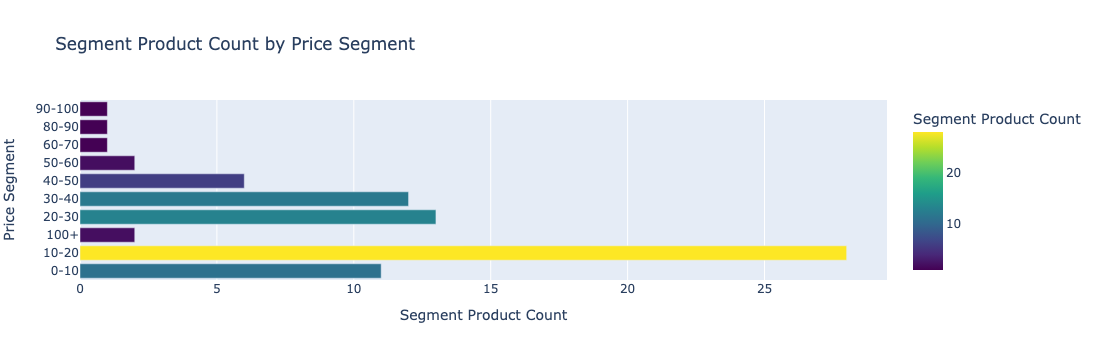

In [147]:
# Yatay çubuk grafik çiz
fig = px.bar(df_visual_unique, y='price_segment', x='segment_product_count', orientation='h', 
             color='segment_product_count', color_continuous_scale='viridis',
             labels={'price_segment': 'Price Segment', 'segment_product_count': 'Segment Product Count'},
             title='Segment Product Count by Price Segment')
fig.show()

In [148]:
#Her bir ürün kategorisi için bölgesel tedarikçilerimizin stoklarının mevcut durumu nedir?

sql = """
SELECT
	c.category_name,
	CASE
		WHEN s.country IN ('Australia', 'Singapore', 'Japan' ) THEN 'Asia-Pacific'
		WHEN s.country IN ('US', 'Brazil', 'Canada') THEN 'America'
		ELSE 'Europe'
	END AS supplier_region,
	p.unit_in_stock AS units_in_stock,
	p.unit_on_order AS units_on_order,
	p.reorder_level 
FROM suppliers AS s
INNER JOIN products AS p
ON s.supplier_id = p.supplier_id
INNER JOIN categories AS c
ON p.category_id = c.category_id
WHERE s.region IS NOT NULL
ORDER BY 
	supplier_region,
	c.category_name,
	p.unit_price;
"""

In [149]:
df = sqlio.read_sql_query(sql,conn)
df.head()

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1600180838.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



category_name supplier_region  units_in_stock  units_on_order  reorder_level
0    Condiments         America             113               0             25
1   Confections         America              17               0              0
2  Meat/Poultry         America              21               0             10
3  Meat/Poultry         America             115               0             20
4     Beverages    Asia-Pacific              15              10             30

In [150]:
df_control = df[df['units_in_stock'] < df['reorder_level']]
df_control.head()

category_name supplier_region  units_in_stock  units_on_order  \
4        Beverages    Asia-Pacific              15              10   
15      Condiments          Europe               4             100   
21  Dairy Products          Europe              22              30   

    reorder_level  
4              30  
15             20  
21             30

CASE 4: Shipper Analizi

In [151]:
sql = """
select 
	ship_name,
	COUNT(order_id) as order_count
from orders
Group by 1
order by 2 desc
"""

In [152]:
df = sqlio.read_sql_query(sql,conn)
df.head()

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1600180838.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



ship_name  order_count
0            Save-a-lot Markets           31
1                  Ernst Handel           30
2                    QUICK-Stop           28
3  Hungry Owl All-Night Grocers           19
4                Folk och fä HB           19

In [153]:
# Çizgi grafiği çiz
fig = px.line(df, x='ship_name', y='order_count', title='Order Count by Ship Name',
              labels={'ship_name': 'Ship Name', 'order_count': 'Order Count'})
fig.update_traces(line=dict(color='royalblue'), mode='lines+markers')
fig.show()

In [154]:
#Nakliyeci başına ortalama yük hesaplama
sql = """
select 
	ship_name,
	ROUND(AVG(freight)::NUMERIC,2) as avg_freight
from orders
Group by 1
order by 2 desc
"""

In [155]:
df = sqlio.read_sql_query(sql,conn)
df.head()

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1600180838.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



ship_name  avg_freight
0            Save-a-lot Markets       215.60
1                  Ernst Handel       206.85
2                    QUICK-Stop       200.20
3                 Queen Cozinha       152.52
4  Hungry Owl All-Night Grocers       145.01

In [157]:
# Çizgi grafiği çiz
fig = px.line(df, x='ship_name', y='avg_freight', title='Average Freight by Ship Name',
              labels={'ship_name': 'Ship Name', 'avg_freight': 'Average Freight'})
fig.update_traces(line=dict(color='royalblue'), mode='lines+markers')
fig.show()

In [165]:
#Nakliyecilerin coğrafi dağılımı

#city kırılımında nakliyeci firma sayısı

sql = """
select 
	o.ship_city,
	COUNT(DISTINCT s.shipper_id) as shipper_count
from shippers s join orders o
on s.shipper_id=o.ship_via
group by 1
order by 2 desc
limit 10
"""

In [168]:
df = sqlio.read_sql_query(sql,conn)
df.head(15)

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1767532659.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



ship_city  shipper_count
0   Albuquerque              3
1     Anchorage              3
2     Barcelona              3
3  Barquisimeto              3
4       Bergamo              3
5        Berlin              3
6          Bern              3
7         Boise              3
8   Brandenburg              3
9        Aachen              3

In [169]:
#Shipperlerın en çok aktif olduğu ilk 10 şehir
import plotly.express as px

# Veriyi sırala
df_sorted = df.sort_values(by='shipper_count', ascending=False)

# Bar grafiğini çiz
fig = px.bar(df_sorted, x='ship_city', y='shipper_count', title='Shipper Count by Ship City',
             labels={'ship_city': 'Ship City', 'shipper_count': 'Shipper Count'})
fig.update_traces(marker_color='skyblue')
fig.update_layout(xaxis_tickangle=-45, xaxis_title='Ship City', yaxis_title='Shipper Count')
fig.show()


In [170]:
#Nakliyecilerin coğrafi dağılımı

#city kırılımında nakliyeci firma sayısı

sql = """
select 
	o.ship_city,
	COUNT(DISTINCT s.shipper_id) as shipper_count
from shippers s join orders o
on s.shipper_id=o.ship_via
group by 1
order by 2 asc
limit 10
"""

In [171]:
df = sqlio.read_sql_query(sql,conn)
df.head(15)

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1767532659.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



ship_city  shipper_count
0      Vancouver              1
1        Caracas              1
2  San Francisco              1
3     Versailles              2
4         Torino              2
5        Münster              2
6       Helsinki              2
7       Kirkland              2
8      Stuttgart              2
9    Walla Walla              2

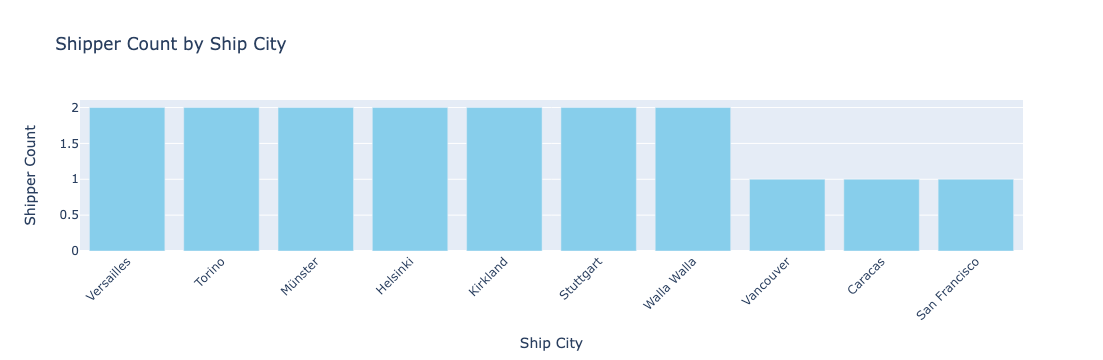

In [172]:
#Shipperlerın en az aktif olduğu ilk 10 şehir
import plotly.express as px

# Veriyi sırala
df_sorted = df.sort_values(by='shipper_count', ascending=False)

# Bar grafiğini çiz
fig = px.bar(df_sorted, x='ship_city', y='shipper_count', title='Shipper Count by Ship City',
             labels={'ship_city': 'Ship City', 'shipper_count': 'Shipper Count'})
fig.update_traces(marker_color='skyblue')
fig.update_layout(xaxis_tickangle=-45, xaxis_title='Ship City', yaxis_title='Shipper Count')
fig.show()

In [175]:
#country kırılımında nakliyeci firma sayısı

sql = """
select 
	o.ship_country,
	COUNT(DISTINCT s.shipper_id) as shipper_count
from shippers s join orders o
on s.shipper_id=o.ship_via
group by 1
order by 2 desc
limit 10
"""

In [176]:
df = sqlio.read_sql_query(sql,conn)
df.head(15)

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1767532659.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



ship_country  shipper_count
0      Austria              3
1      Belgium              3
2       Brazil              3
3       Canada              3
4      Denmark              3
5      Finland              3
6       France              3
7      Germany              3
8      Ireland              3
9    Argentina              3

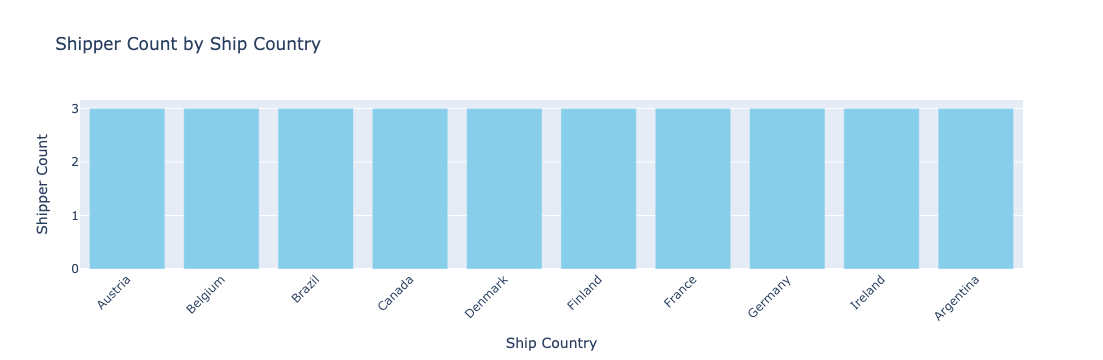

In [177]:
#Shipperlerın en çok aktif olduğu ilk 10 ülke
import plotly.express as px

# Veriyi sırala
df_sorted = df.sort_values(by='shipper_count', ascending=False)

# Bar grafiğini çiz
fig = px.bar(df_sorted, x='ship_country', y='shipper_count', title='Shipper Count by Ship Country',
             labels={'ship_country': 'Ship Country', 'shipper_count': 'Shipper Count'})
fig.update_traces(marker_color='skyblue')
fig.update_layout(xaxis_tickangle=-45, xaxis_title='Ship Country', yaxis_title='Shipper Count')
fig.show()

In [185]:
#region kırılımında nakliyeci firma sayısı

sql = """
select 
	o.ship_region,
	COUNT(DISTINCT s.shipper_id) as shipper_count
from shippers s join orders o
on s.shipper_id=o.ship_via
group by 1
order by 2 desc
limit 10
"""

In [186]:
df = sqlio.read_sql_query(sql,conn)
df.head(15)

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1767532659.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



ship_region  shipper_count
0           None              3
1             BC              3
2             WY              3
3             AK              3
4       Co. Cork              3
5          Essex              3
6             ID              3
7  Isle of Wight              3
8           Lara              3
9             MT              3

In [189]:
#Shipperlerın en çok aktif olduğu ilk 10 bölge
import plotly.express as px

# Veriyi sırala
df_sorted = df.sort_values(by='ship_region', ascending=False)

# Bar grafiğini çiz
fig = px.bar(df_sorted, x='ship_region', y='shipper_count', title='Shipper Count by Ship Region',
             labels={'ship_region': 'Ship Region', 'shipper_count': 'Shipper Count'})
fig.update_traces(marker_color='skyblue')
fig.update_layout(xaxis_tickangle=-45, xaxis_title='Ship Region', yaxis_title='Shipper Count')
fig.show()

In [190]:
#Her shipper_company'de aktif olan kaç ship var

sql = """
WITH ship_via_with_ship_count AS (
select 
	ship_via,
	COUNT(DISTINCT ship_name) as ship_count
from orders
group by 1
order by 2 desc
) select 
	s.company_name,
	sc.ship_count
from ship_via_with_ship_count sc join shippers s
on sc.ship_via = s.shipper_id
"""

In [191]:
df = sqlio.read_sql_query(sql,conn)
df.head()

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1600180838.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



company_name  ship_count
0    Speedy Express          79
1    United Package          83
2  Federal Shipping          78

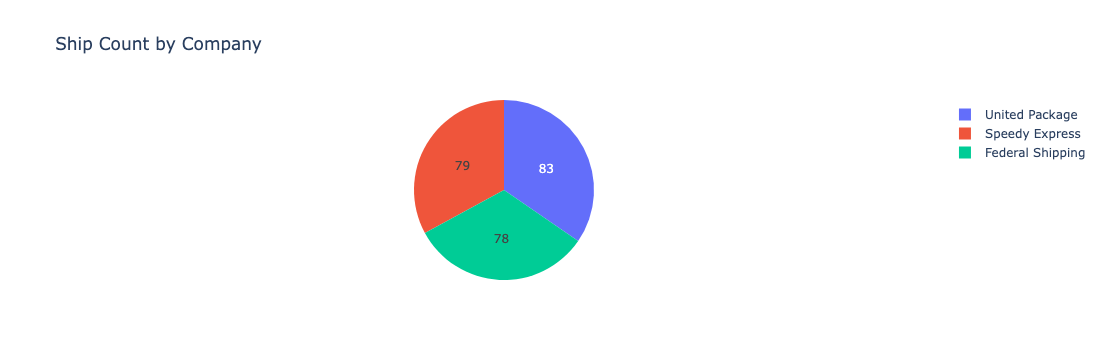

In [197]:
# Pasta grafiğini çiz
fig = px.pie(df, values=df['ship_count'], names=df['company_name'], title='Ship Count by Company')
fig.update_traces(textinfo='text', text=df['ship_count'])
fig.show()

CASE 5: Supplier Analizi

In [198]:
#Tedarikçilerin coğrafi dağılımlarını analiz etme

#Country kırılımında tedarikçi sayısı en fazla olan 10 ülke görselleştir

sql = """
Select 
	country,
	count(supplier_id) as supplier_count
from suppliers
group by country
order by 2 desc
limit 10
"""

In [201]:
df = sqlio.read_sql_query(sql,conn)
df.head()

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1600180838.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



country  supplier_count
0      USA               4
1   France               3
2  Germany               3
3    Italy               2
4   Sweden               2

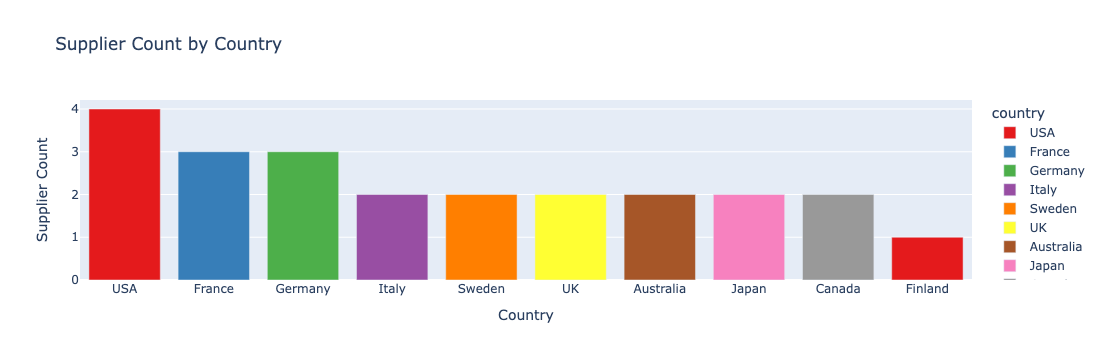

In [203]:
# Bar grafiğini çiz
fig = px.bar(df, x='country', y='supplier_count', title='Supplier Count by Country', 
             color='country', color_discrete_sequence=px.colors.qualitative.Set1)
fig.update_xaxes(title='Country')
fig.update_yaxes(title='Supplier Count')
fig.show()

In [204]:
#Region kırılımında tedarikçi sayısı en fazla olan ilk 10 ülke

sql = """
Select 
	region,
	count(supplier_id) as supplier_count
from suppliers
group by region
order by 2 desc
limit 10
"""

In [205]:
df = sqlio.read_sql_query(sql,conn)
df.head()

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1600180838.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



region  supplier_count
0    None              20
1  Québec               2
2      LA               1
3      MI               1
4      MA               1

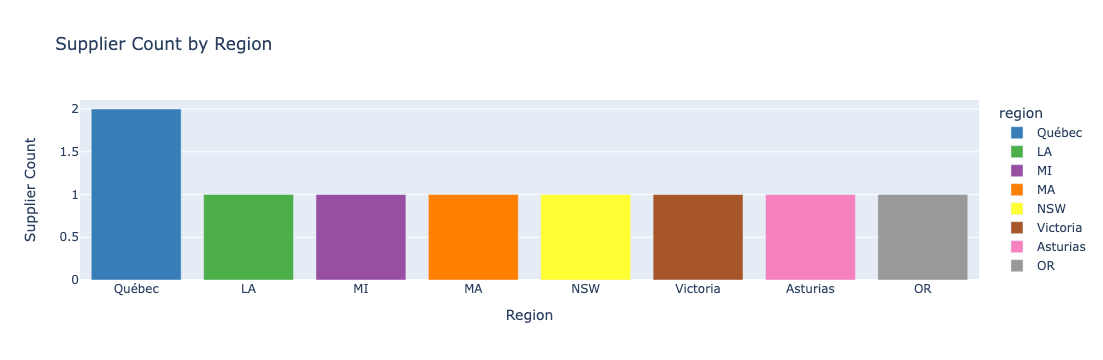

In [206]:
# Bar grafiğini çiz
fig = px.bar(df, x='region', y='supplier_count', title='Supplier Count by Region', 
             color='region', color_discrete_sequence=px.colors.qualitative.Set1)
fig.update_xaxes(title='Region')
fig.update_yaxes(title='Supplier Count')
fig.show()

In [207]:
#Her bir ürün kategorisinde kaç tedarikçi sayısı var?

sql = """
WITH categories_suppliers_count AS
(
select 
	p.category_id,
	count(p.supplier_id) as supplier_count
from
suppliers s join products p
on s.supplier_id = p.supplier_id
group by p.category_id
) select 
		csc.category_id,
		c.category_name,
		csc.supplier_count
	from 
	categories_suppliers_count csc join categories c
	ON csc.category_id = c.category_id
 """

In [208]:
df = sqlio.read_sql_query(sql,conn)
df.head()

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1600180838.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



category_id   category_name  supplier_count
0            1       Beverages              12
1            2      Condiments              12
2            3     Confections              13
3            4  Dairy Products              10
4            5  Grains/Cereals               7

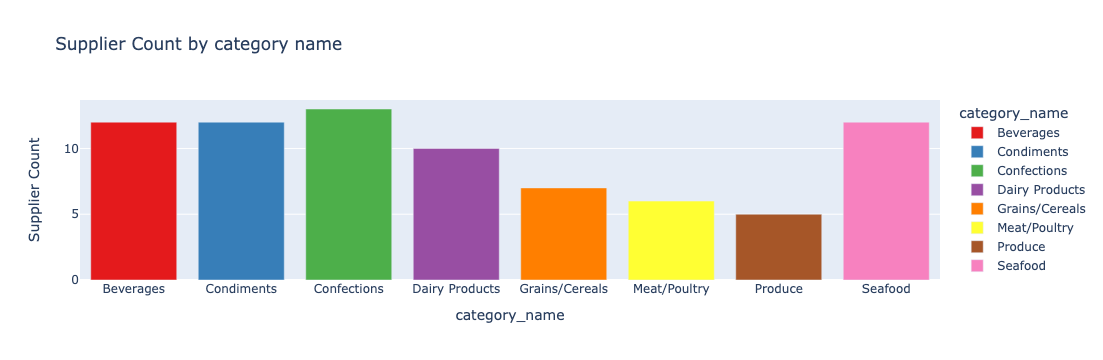

In [209]:
# Bar grafiğini çiz
fig = px.bar(df, x='category_name', y='supplier_count', title='Supplier Count by category name', 
             color='category_name', color_discrete_sequence=px.colors.qualitative.Set1)
fig.update_xaxes(title='category_name')
fig.update_yaxes(title='Supplier Count')
fig.show()

In [210]:
#En çok sipariş alan ilk 10 tedarikçi kimdir?

sql = """
WITH suppliers_with_ordercount AS (
select 
	s.supplier_id,
	count(o.order_id) as order_count
from suppliers s join products p
on s.supplier_id = p.supplier_id
join order_details od on od.product_id = p.product_id
join orders o on o.order_id = od.order_id
group by s.supplier_id
order by order_count desc
limit 10
) select 
	s.company_name,
	swo.order_count
from suppliers_with_ordercount swo join suppliers s
on swo.supplier_id = s.supplier_id
"""

In [211]:
df = sqlio.read_sql_query(sql,conn)
df.head()

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1600180838.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



company_name  order_count
0                      Pavlova, Ltd.          163
1           Specialty Biscuits, Ltd.          164
2  Plutzer Lebensmittelgroßmärkte AG          179
3            Formaggi Fortini s.r.l.          104
4                    Norske Meierier          105

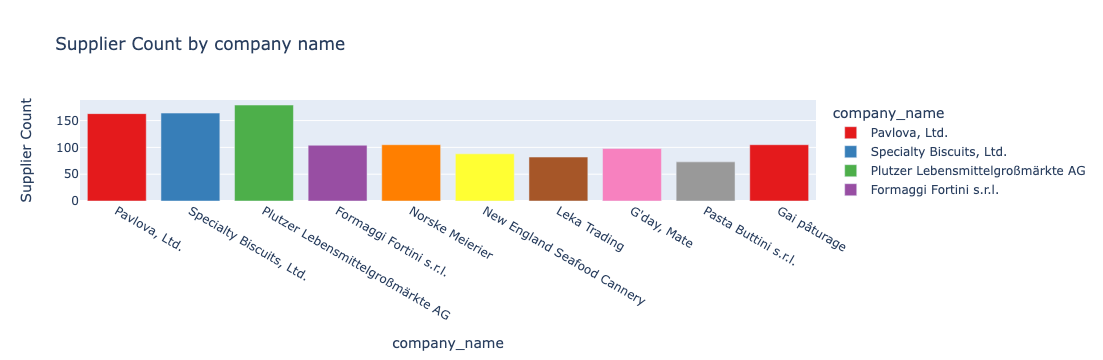

In [212]:
# Bar grafiğini çiz
fig = px.bar(df, x='company_name', y='order_count', title='Supplier Count by company name', 
             color='company_name', color_discrete_sequence=px.colors.qualitative.Set1)
fig.update_xaxes(title='company_name')
fig.update_yaxes(title='Supplier Count')
fig.show()

In [213]:
#Her bir kategoride en hızlı teslimat süresine sahip tedarikçileri analiz etmek

sql = """
WITH fast_supplier AS (
select 
	s.supplier_id,
	p.category_id,
	MIN(o.shipped_date - o.order_date) AS min_delivery_days
from suppliers s join products p
on s.supplier_id = p.supplier_id
join order_details od on od.product_id = p.product_id
join orders o on o.order_id = od.order_id
WHERE o.shipped_date IS NOT NULL
group by 1, 2
order by 3
) select 
		s.company_name,
		c.category_name,
		fs.min_delivery_days
	from fast_supplier fs join suppliers s 
	on fs.supplier_id = s.supplier_id
	join categories c on c.category_id=fs.category_id
"""

In [214]:
df = sqlio.read_sql_query(sql,conn)
df.head()

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1600180838.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



company_name category_name  min_delivery_days
0                        G'day, Mate  Meat/Poultry                  1
1                  Svensk Sjöföda AB       Seafood                  1
2                      Pavlova, Ltd.     Beverages                  1
3         New Orleans Cajun Delights    Condiments                  1
4  Plutzer Lebensmittelgroßmärkte AG    Condiments                  1

In [216]:
unique_category_count = df['category_name'].nunique()
print("Unique category count:", unique_category_count)

Unique category count: 8


In [220]:
unique_company_count = df['company_name'].nunique()
print("Unique company count:", unique_company_count)


Unique company count: 29


In [224]:
#Pavlova,Ltd hangi kategoriyi kaç günde iletiyor?
df_Pavlova = df[df['company_name'] == 'Pavlova, Ltd.']
df_Pavlova.head()

company_name category_name  min_delivery_days
2   Pavlova, Ltd.     Beverages                  1
7   Pavlova, Ltd.   Confections                  1
13  Pavlova, Ltd.  Meat/Poultry                  1
24  Pavlova, Ltd.    Condiments                  2
27  Pavlova, Ltd.       Seafood                  2

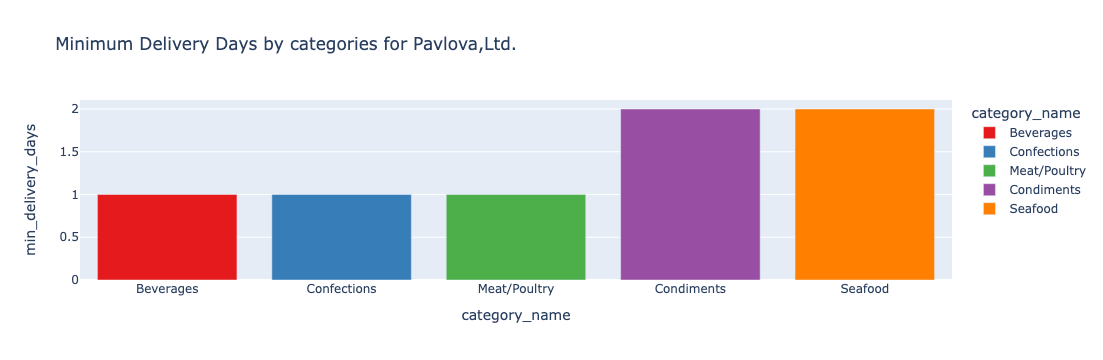

In [226]:
# Bar grafiğini çiz
fig = px.bar(df_Pavlova, x='category_name', y='min_delivery_days', title='Minimum Delivery Days by categories for Pavlova,Ltd.', 
             color='category_name', color_discrete_sequence=px.colors.qualitative.Set1)
fig.update_xaxes(title='category_name')
fig.update_yaxes(title='min_delivery_days')
fig.show()

In [230]:
#Condiments ürün kategorisi için 1 gün süre ile iletim yapan firmalar hangileri?

df_condiments = df[(df['min_delivery_days'] == 1) & (df['category_name'] == 'Condiments')]
df_condiments.head()

company_name category_name  min_delivery_days
3         New Orleans Cajun Delights    Condiments                  1
4  Plutzer Lebensmittelgroßmärkte AG    Condiments                  1
5                       Leka Trading    Condiments                  1

In [231]:
#İşletmenin en çok para harcadığı ilk 10 tedarikçi listesini görselleştirme
#discount oranları da hesaplanmıştır.
sql = """
select 
	s.supplier_id,
	s.company_name,
	ROUND(SUM(CASE WHEN od.discount = 0 THEN od.unit_price * od.quantity ELSE (od.unit_price * od.quantity) * (1 - od.discount / 100) END)::NUMERIC, 2) as amount
from suppliers s join products p
on s.supplier_id = p.supplier_id
join order_details od on od.product_id=p.product_id
Group by 1,2
order by 3 desc
limit 10
"""

In [232]:
df = sqlio.read_sql_query(sql,conn)
df.head()

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1600180838.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



supplier_id                       company_name     amount
0           18         Aux joyeux ecclésiastiques  163040.56
1           12  Plutzer Lebensmittelgroßmärkte AG  155840.81
2           28                       Gai pâturage  126495.99
3            7                      Pavlova, Ltd.  115296.79
4           24                        G'day, Mate   69596.50

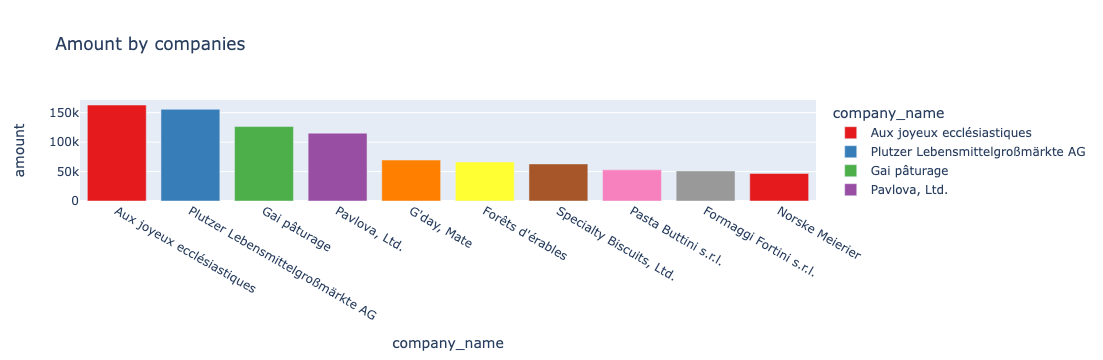

In [234]:
# Bar grafiğini çiz
fig = px.bar(df, x='company_name', y='amount', title='Amount by companies', 
             color='company_name', color_discrete_sequence=px.colors.qualitative.Set1)
fig.update_xaxes(title='company_name')
fig.update_yaxes(title='amount')
fig.show()

In [245]:
#En çok siparişe sahip ilk 10 tedarikçinin yıllık maliyet analizi

sql = """
WITH suppliers_with_ordercount AS (
    SELECT 
        s.supplier_id,
        s.company_name,
        COUNT(o.order_id) AS order_count
    FROM 
        suppliers s 
    JOIN 
        products p ON s.supplier_id = p.supplier_id
    JOIN 
        order_details od ON od.product_id = p.product_id
    JOIN 
        orders o ON o.order_id = od.order_id
    GROUP BY 
        s.supplier_id, s.company_name
    ORDER BY 
        order_count DESC
    LIMIT 10
),supplier_sales AS (
    SELECT 
        s.company_name,
        EXTRACT(YEAR FROM o.order_date) AS order_year,
        ROUND(SUM(CASE WHEN od.discount = 0 THEN od.unit_price * od.quantity ELSE (od.unit_price * od.quantity) * (1 - od.discount / 100) END)::NUMERIC, 2) AS total_price
    FROM 
        suppliers s 
    JOIN 
        products p ON s.supplier_id = p.supplier_id
    JOIN 
        order_details od ON od.product_id = p.product_id
    JOIN 
        orders o ON o.order_id = od.order_id
    WHERE 
        s.company_name IN (SELECT company_name FROM suppliers_with_ordercount)
    GROUP BY 
        s.company_name, order_year
)
SELECT 
    company_name,
    order_year,
    total_price
FROM 
    supplier_sales
"""

In [246]:
df = sqlio.read_sql_query(sql,conn)
df.head()

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1600180838.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



company_name  order_year  total_price
0  Pasta Buttini s.r.l.      1996.0      4991.53
1          Gai pâturage      1996.0     20206.32
2         Pavlova, Ltd.      1997.0     59614.21
3          Gai pâturage      1997.0     59676.70
4       Norske Meierier      1998.0     12710.63

In [247]:
df_96 = df[df['order_year'] == 1996]
df_96.head()

company_name  order_year  total_price
0         Pasta Buttini s.r.l.      1996.0      4991.53
1                 Gai pâturage      1996.0     20206.32
6              Norske Meierier      1996.0      9171.39
7                  G'day, Mate      1996.0     12696.21
9  New England Seafood Cannery      1996.0      3873.69

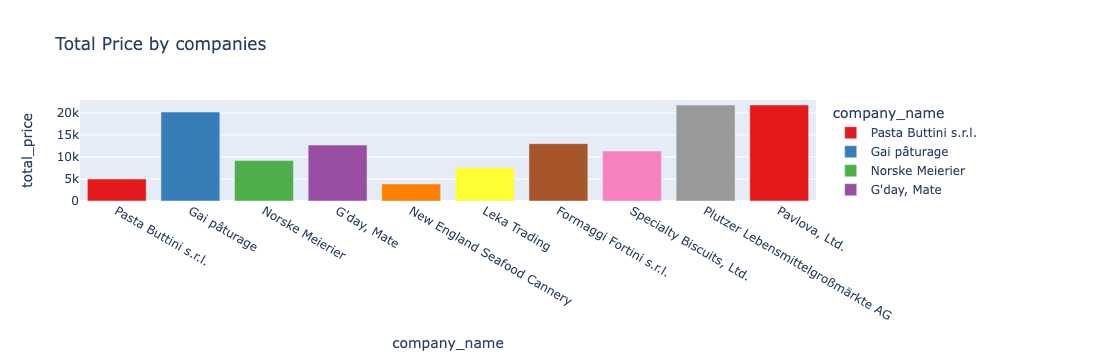

In [250]:
# Bar grafiğini çiz
fig = px.bar(df_96, x='company_name', y='total_price', title='Total Price by companies', 
             color='company_name', color_discrete_sequence=px.colors.qualitative.Set1)
fig.update_xaxes(title='company_name')
fig.update_yaxes(title='total_price')
fig.show()

In [248]:
df_97 = df[df['order_year'] == 1997]
df_97.head()

company_name  order_year  total_price
2                       Pavlova, Ltd.      1997.0     59614.21
3                        Gai pâturage      1997.0     59676.70
5   Plutzer Lebensmittelgroßmärkte AG      1997.0     69292.45
11           Specialty Biscuits, Ltd.      1997.0     26470.79
12                    Norske Meierier      1997.0     24977.63

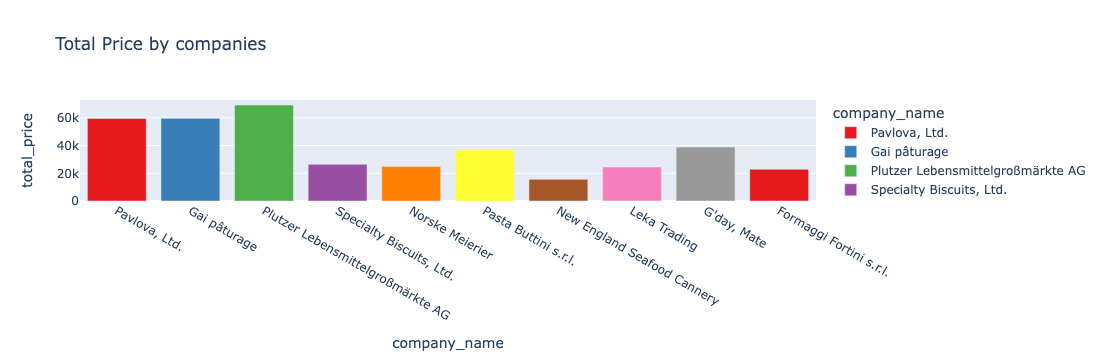

In [251]:
# Bar grafiğini çiz
fig = px.bar(df_97, x='company_name', y='total_price', title='Total Price by companies', 
             color='company_name', color_discrete_sequence=px.colors.qualitative.Set1)
fig.update_xaxes(title='company_name')
fig.update_yaxes(title='total_price')
fig.show()

In [253]:
df_98 = df[df['order_year'] == 1998]
df_98.head()

company_name  order_year  total_price
4            Norske Meierier      1998.0     12710.63
8       Pasta Buttini s.r.l.      1998.0     10897.18
10               G'day, Mate      1998.0     17942.27
13  Specialty Biscuits, Ltd.      1998.0     25222.04
17              Leka Trading      1998.0     12771.80

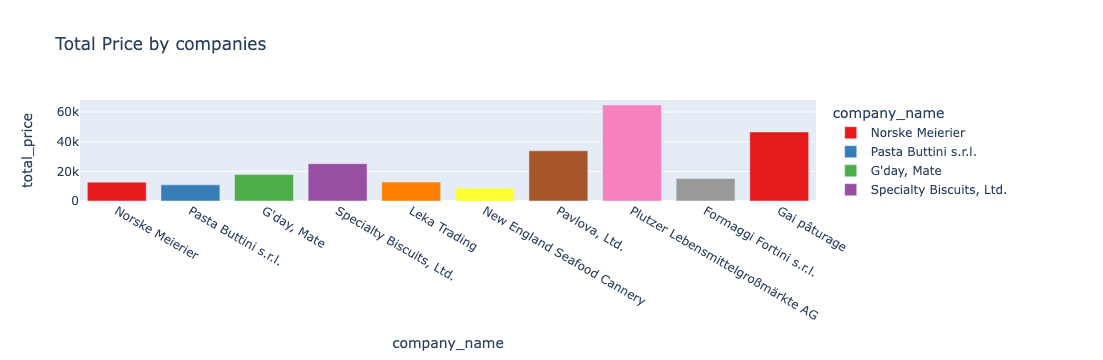

In [254]:
# Bar grafiğini çiz
fig = px.bar(df_98, x='company_name', y='total_price', title='Total Price by companies', 
             color='company_name', color_discrete_sequence=px.colors.qualitative.Set1)
fig.update_xaxes(title='company_name')
fig.update_yaxes(title='total_price')
fig.show()

CASE 6: Employee Analizi

In [255]:
#En çok sipariş işleyen çalışanlar

sql = """
WITH employee_with_ordercount AS (
select 
	e.employee_id,
	count(order_id) as order_count
from employees e join orders o
on e.employee_id = o.employee_id
WHERE TO_CHAR(order_date, 'YYYY') = '1998'
group by 1
order by 2 desc
) select 
	e.first_name,
	e.last_name,
	e.title,
	eo.order_count
from employee_with_ordercount eo join employees e
on eo.employee_id = e.employee_id
order by 4 desc
"""

In [257]:
df = sqlio.read_sql_query(sql,conn)
df.head(15)

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1767532659.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



first_name  last_name                     title  order_count
0   Margaret    Peacock      Sales Representative           44
1      Nancy    Davolio      Sales Representative           42
2     Andrew     Fuller     Vice President, Sales           39
3      Janet  Leverling      Sales Representative           38
4      Laura   Callahan  Inside Sales Coordinator           31
5     Robert       King      Sales Representative           25
6       Anne  Dodsworth      Sales Representative           19
7    Michael     Suyama      Sales Representative           19
8     Steven   Buchanan             Sales Manager           13

In [260]:
df['fullname'] = df['first_name']+' '+df['last_name']

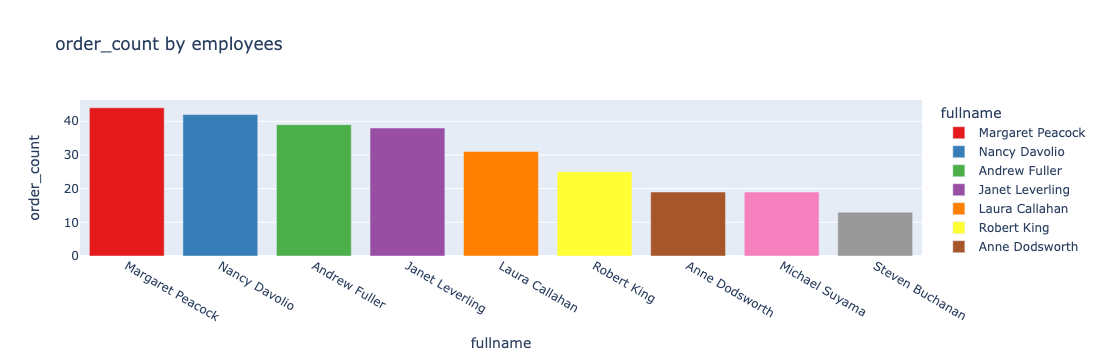

In [261]:
# Bar grafiğini çiz
fig = px.bar(df, x='fullname', y='order_count', title='order_count by employees', 
             color='fullname', color_discrete_sequence=px.colors.qualitative.Set1)
fig.update_xaxes(title='fullname')
fig.update_yaxes(title='order_count')
fig.show()

In [262]:
#Tedarikçiden en yüksek indirim oranını alan çalışanlar

sql = """
WITH employee_with_discount AS 
(
select 
	e.employee_id,
	ROUND(SUM(od.discount)::NUMERIC,2) as total_discount
from employees e join orders o 
on e.employee_id = o.employee_id
join order_details od on od.order_id = o.order_id
WHERE TO_CHAR(order_date, 'YYYY') = '1998'
GROUP BY 1
ORDER BY 2 DESC
) select 
	e.first_name,
	e.last_name,
	e.title,
	ed.total_discount
from employee_with_discount ed join employees e
on ed.employee_id = e.employee_id
order by 4 desc
"""

In [263]:
df = sqlio.read_sql_query(sql,conn)
df.head(15)

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1767532659.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



first_name  last_name                     title  total_discount
0      Janet  Leverling      Sales Representative            6.85
1   Margaret    Peacock      Sales Representative            6.50
2      Nancy    Davolio      Sales Representative            5.24
3     Andrew     Fuller     Vice President, Sales            4.60
4     Robert       King      Sales Representative            4.40
5      Laura   Callahan  Inside Sales Coordinator            3.70
6     Steven   Buchanan             Sales Manager            2.25
7       Anne  Dodsworth      Sales Representative            1.90
8    Michael     Suyama      Sales Representative            1.30

In [264]:
df['fullname'] = df['first_name']+' '+df['last_name']

In [265]:
df.head()

first_name  last_name                  title  total_discount  \
0      Janet  Leverling   Sales Representative            6.85   
1   Margaret    Peacock   Sales Representative            6.50   
2      Nancy    Davolio   Sales Representative            5.24   
3     Andrew     Fuller  Vice President, Sales            4.60   
4     Robert       King   Sales Representative            4.40   

           fullname  
0   Janet Leverling  
1  Margaret Peacock  
2     Nancy Davolio  
3     Andrew Fuller  
4       Robert King

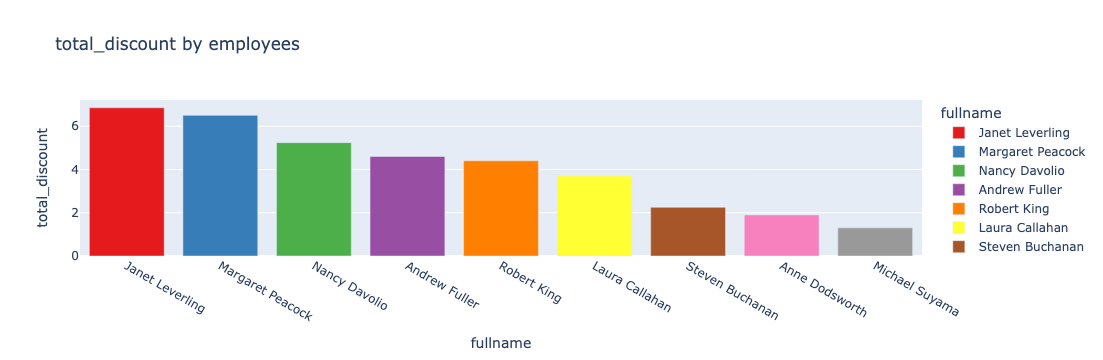

In [266]:
# Bar grafiğini çiz
fig = px.bar(df, x='fullname', y='total_discount', title='total_discount by employees', 
             color='fullname', color_discrete_sequence=px.colors.qualitative.Set1)
fig.update_xaxes(title='fullname')
fig.update_yaxes(title='total_discount')
fig.show()

In [267]:
#Her bir çalışanın kaç bölgesi var?

sql = """
WITH employees_with_territory AS (
select 
	e.employee_id,
	count(et.territory_id) as territory_count
from 
employees e join employeeterritories et
on e.employee_id = et.employee_id
group by 1
order by 2 desc
) select 
	e.first_name,
	e.last_name,
	e.title,
	et.territory_count
from employees_with_territory et
join employees e on e.employee_id = et.employee_id
ORDER BY 4 desc
"""

In [268]:
df = sqlio.read_sql_query(sql,conn)
df.head(15)

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1767532659.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



first_name  last_name                     title  territory_count
0     Robert       King      Sales Representative               10
1     Andrew     Fuller     Vice President, Sales                7
2       Anne  Dodsworth      Sales Representative                7
3     Steven   Buchanan             Sales Manager                7
4    Michael     Suyama      Sales Representative                5
5      Janet  Leverling      Sales Representative                4
6      Laura   Callahan  Inside Sales Coordinator                4
7   Margaret    Peacock      Sales Representative                3
8      Nancy    Davolio      Sales Representative                2

In [269]:
df['fullname'] = df['first_name']+' '+df['last_name']
df.head()

first_name  last_name                  title  territory_count  \
0     Robert       King   Sales Representative               10   
1     Andrew     Fuller  Vice President, Sales                7   
2       Anne  Dodsworth   Sales Representative                7   
3     Steven   Buchanan          Sales Manager                7   
4    Michael     Suyama   Sales Representative                5   

          fullname  
0      Robert King  
1    Andrew Fuller  
2   Anne Dodsworth  
3  Steven Buchanan  
4   Michael Suyama

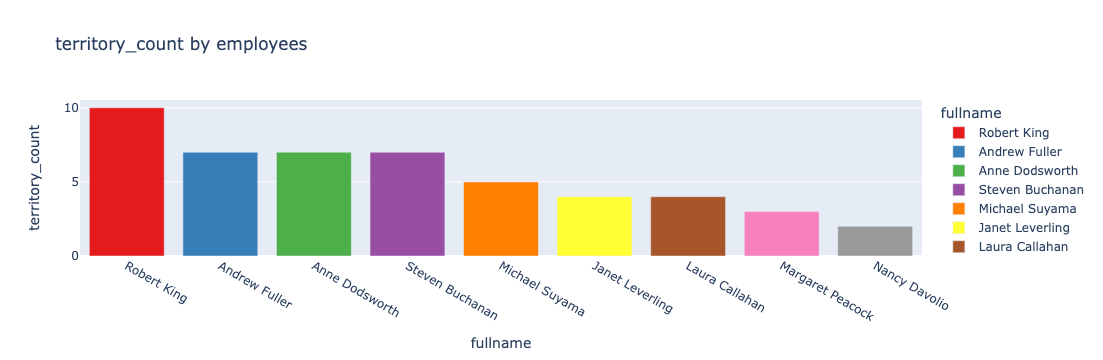

In [270]:
# Bar grafiğini çiz
fig = px.bar(df, x='fullname', y='territory_count', title='territory_count by employees', 
             color='fullname', color_discrete_sequence=px.colors.qualitative.Set1)
fig.update_xaxes(title='fullname')
fig.update_yaxes(title='territory_count')
fig.show()

CASE 7: Stok analizi

In [271]:
#Yeniden sipariş seviyesinin altında kalan stock sayıları için sipariş verilmiş mi?
#Verilmemişse kritik olarak kategorilendir.
#Verilmiş ancak gene de reorder_level altındaysa yetersiz olarak kategorilendir
#ELSE Uygun olarak kategorilendir

sql = """
SELECT 
    product_id,
    category_id,
    unit_in_stock,
    reorder_level,
    unit_on_order,
    CASE
        WHEN unit_on_order = 0 THEN 'Kritik Durum!'
        WHEN unit_on_order + unit_in_stock < reorder_level THEN 'Yetersiz'
        ELSE 'Uygun'
    END AS stock_status
FROM 
    products
WHERE 
    unit_in_stock < reorder_level;
"""

In [272]:
df = sqlio.read_sql_query(sql,conn)
df.head(15)

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1767532659.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



product_id  category_id  unit_in_stock  reorder_level  unit_on_order  \
0            2            1             17             25             40   
1            3            2             13             25             70   
2           11            4             22             30             30   
3           21            3              3              5             40   
4           30            8             10             15              0   
5           31            4              0             20             70   
6           32            4              9             25             40   
7           37            8             11             25             50   
8           43            1             17             25             10   
9           45            8              5             15             70   
10          48            3             15             25             70   
11          49            3             10             15             60   
12          56            5             21             30             10   
13          64            5             22             30             80   
14          66            2              4             20            100   

     stock_status  
0           Uygun  
1           Uygun  
2           Uygun  
3           Uygun  
4   Kritik Durum!  
5           Uygun  
6           Uygun  
7           Uygun  
8           Uygun  
9           Uygun  
10          Uygun  
11          Uygun  
12          Uygun  
13          Uygun  
14          Uygun

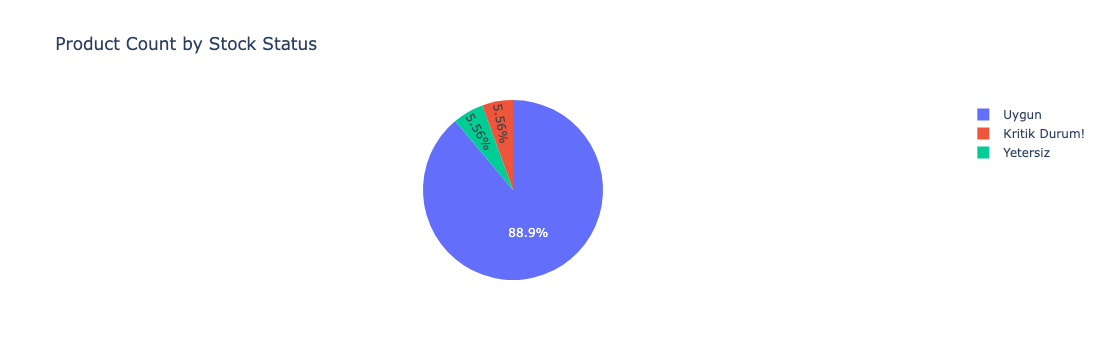

In [274]:
# Stok durumuna göre ürün sayısını say
product_count_by_status = df.groupby('stock_status')['product_id'].count().reset_index(name='count')

# Pasta grafiğini çiz
fig = px.pie(product_count_by_status, values='count', names='stock_status', title='Product Count by Stock Status')
fig.show()

CASE 8: RFM Analizi

In [321]:
sql = """ select * from orders"""

In [322]:
df1 = sqlio.read_sql_query(sql,conn)
df1.head(15)

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/2097893614.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



order_id customer_id  employee_id  order_date required_date shipped_date  \
0      10248       VINET            5  1996-07-04    1996-08-01   1996-07-16   
1      10249       TOMSP            6  1996-07-05    1996-08-16   1996-07-10   
2      10250       HANAR            4  1996-07-08    1996-08-05   1996-07-12   
3      10251       VICTE            3  1996-07-08    1996-08-05   1996-07-15   
4      10252       SUPRD            4  1996-07-09    1996-08-06   1996-07-11   
5      10253       HANAR            3  1996-07-10    1996-07-24   1996-07-16   
6      10254       CHOPS            5  1996-07-11    1996-08-08   1996-07-23   
7      10255       RICSU            9  1996-07-12    1996-08-09   1996-07-15   
8      10256       WELLI            3  1996-07-15    1996-08-12   1996-07-17   
9      10257       HILAA            4  1996-07-16    1996-08-13   1996-07-22   
10     10258       ERNSH            1  1996-07-17    1996-08-14   1996-07-23   
11     10259       CENTC            4  1996-07-18    1996-08-15   1996-07-25   
12     10260       OTTIK            4  1996-07-19    1996-08-16   1996-07-29   
13     10261       QUEDE            4  1996-07-19    1996-08-16   1996-07-30   
14     10262       RATTC            8  1996-07-22    1996-08-19   1996-07-25   

    ship_via  freight                   ship_name  \
0          3    32.38   Vins et alcools Chevalier   
1          1    11.61          Toms Spezialitäten   
2          2    65.83               Hanari Carnes   
3          1    41.34        Victuailles en stock   
4          2    51.30            Suprêmes délices   
5          2    58.17               Hanari Carnes   
6          2    22.98           Chop-suey Chinese   
7          3   148.33          Richter Supermarkt   
8          2    13.97      Wellington Importadora   
9          3    81.91            HILARION-Abastos   
10         1   140.51                Ernst Handel   
11         3     3.25  Centro comercial Moctezuma   
12         1    55.09          Ottilies Käseladen   
13         2     3.05                 Que Delícia   
14         3    48.29  Rattlesnake Canyon Grocery   

                                  ship_address       ship_city ship_region  \
0                           59 rue de l'Abbaye           Reims        None   
1                                Luisenstr. 48         Münster        None   
2                              Rua do Paço, 67  Rio de Janeiro          RJ   
3                           2, rue du Commerce            Lyon        None   
4                         Boulevard Tirou, 255       Charleroi        None   
5                              Rua do Paço, 67  Rio de Janeiro          RJ   
6                                 Hauptstr. 31            Bern        None   
7                                  Starenweg 5          Genève        None   
8                           Rua do Mercado, 12         Resende          SP   
9   Carrera 22 con Ave. Carlos Soublette #8-35   San Cristóbal     Táchira   
10                                Kirchgasse 6            Graz        None   
11                     Sierras de Granada 9993     México D.F.        None   
12                          Mehrheimerstr. 369            Köln        None   
13                     Rua da Panificadora, 12  Rio de Janeiro          RJ   
14                             2817 Milton Dr.     Albuquerque          NM   

   ship_postal_code ship_country  
0             51100       France  
1             44087      Germany  
2         05454-876       Brazil  
3             69004       France  
4            B-6000      Belgium  
5         05454-876       Brazil  
6              3012  Switzerland  
7              1204  Switzerland  
8         08737-363       Brazil  
9              5022    Venezuela  
10             8010      Austria  
11            05022       Mexico  
12            50739      Germany  
13        02389-673       Brazil  
14            87110          USA

In [323]:
sql = """ select * from order_details"""

In [324]:
df2 = sqlio.read_sql_query(sql,conn)
df2.head(15)

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/1498267876.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



order_id  product_id  unit_price  quantity  discount
0      10248          11        14.0        12      0.00
1      10248          42         9.8        10      0.00
2      10248          72        34.8         5      0.00
3      10249          14        18.6         9      0.00
4      10249          51        42.4        40      0.00
5      10250          41         7.7        10      0.00
6      10250          51        42.4        35      0.15
7      10250          65        16.8        15      0.15
8      10251          22        16.8         6      0.05
9      10251          57        15.6        15      0.05
10     10251          65        16.8        20      0.00
11     10252          20        64.8        40      0.05
12     10252          33         2.0        25      0.05
13     10252          60        27.2        40      0.00
14     10253          31        10.0        20      0.00

In [325]:
# orders ve order_details veri çerçevelerini birleştir
df_merged = pd.merge(df1, df2, on='order_id', how='inner')

In [326]:
df_merged.head()

order_id customer_id  employee_id  order_date required_date shipped_date  \
0     10248       VINET            5  1996-07-04    1996-08-01   1996-07-16   
1     10248       VINET            5  1996-07-04    1996-08-01   1996-07-16   
2     10248       VINET            5  1996-07-04    1996-08-01   1996-07-16   
3     10249       TOMSP            6  1996-07-05    1996-08-16   1996-07-10   
4     10249       TOMSP            6  1996-07-05    1996-08-16   1996-07-10   

   ship_via  freight                  ship_name        ship_address ship_city  \
0         3    32.38  Vins et alcools Chevalier  59 rue de l'Abbaye     Reims   
1         3    32.38  Vins et alcools Chevalier  59 rue de l'Abbaye     Reims   
2         3    32.38  Vins et alcools Chevalier  59 rue de l'Abbaye     Reims   
3         1    11.61         Toms Spezialitäten       Luisenstr. 48   Münster   
4         1    11.61         Toms Spezialitäten       Luisenstr. 48   Münster   

  ship_region ship_postal_code ship_country  product_id  unit_price  quantity  \
0        None            51100       France          11        14.0        12   
1        None            51100       France          42         9.8        10   
2        None            51100       France          72        34.8         5   
3        None            44087      Germany          14        18.6         9   
4        None            44087      Germany          51        42.4        40   

   discount  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0

In [327]:
# Müşterilerin en son sipariş tarihlerini hesapla
last_order_date = df_merged.groupby('customer_id')['order_date'].max().reset_index()
last_order_date.rename(columns={'order_date': 'last_order_date'}, inplace=True)


In [328]:
# "recency" değerini hesapla
max_order_date = df_merged['order_date'].max()


In [329]:
last_order_date['recency'] = max_order_date - last_order_date['last_order_date']

# "recency" değeri sıfır olmayan müşterileri seç
last_order_date = last_order_date[last_order_date['recency'] != pd.Timedelta(days=0)]

# Sonuçları göster
last_order_date.head()

customer_id last_order_date recency
0       ALFKI      1998-04-09 27 days
1       ANATR      1998-03-04 63 days
2       ANTON      1998-01-28 98 days
3       AROUT      1998-04-10 26 days
4       BERGS      1998-03-04 63 days

In [330]:
print(len(last_order_date))

85


In [331]:
# customer_id'ye göre gruplayıp 'order_id' sütununu sayıyoruz
frequency_df = df1.groupby('customer_id').size().reset_index(name='frequency')

# Frekans sütununa göre sıralama yapıyoruz
frequency_df = frequency_df.sort_values(by='frequency', ascending=True)

print(len(frequency_df))

89


In [332]:
frequency_df.head(90)

customer_id  frequency
12       CENTC          1
31       GROSR          2
41       LAZYK          2
40       LAUGB          3
79       TRAIH          3
..         ...        ...
22       FOLKO         19
35       HUNGO         19
60       QUICK         28
19       ERNSH         30
68       SAVEA         31

[89 rows x 2 columns]

In [333]:
# Müşteri ve parasal değerleri seç Monetary için:
monetary_values = df_merged[['customer_id', 'unit_price', 'quantity']]

In [334]:
# Parasal değeri hesapla
monetary_values['monetary'] = monetary_values['unit_price'] * monetary_values['quantity']

/var/folders/j8/y26q1nxs4qs9jlvz8s72t9rm0000gn/T/ipykernel_2952/3815682363.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [335]:
# Müşterilere göre toplam parasal değeri grupla
monetary_df = monetary_values.groupby('customer_id')['monetary'].sum().reset_index()

In [336]:
# Parasal değere göre sırala
monetary_df = monetary_df.sort_values(by='monetary')

monetary_df.head()

customer_id  monetary
12       CENTC     100.8
41       LAZYK     357.0
40       LAUGB     522.5
51       NORTS     649.0
27       GALED     836.7

In [337]:
print(len(monetary_df))

89


In [338]:
# frequency_df ve monetary_df veri çerçevelerini customer_id üzerinde birleştir
merged_df = pd.merge(frequency_df, monetary_df, on='customer_id', how='inner')

# merged_df ve last_order_date veri çerçevelerini customer_id üzerinde birleştir
final_df = pd.merge(merged_df, last_order_date, on='customer_id', how='inner')

print(final_df)

   customer_id  frequency   monetary last_order_date  recency
0        CENTC          1     100.80      1996-07-18 657 days
1        GROSR          2    1488.70      1997-12-18 139 days
2        LAZYK          2     357.00      1997-05-22 349 days
3        LAUGB          3     522.50      1998-01-01 125 days
4        TRAIH          3    1571.20      1998-01-08 118 days
..         ...        ...        ...             ...      ...
80       FOLKO         19   32555.55      1998-04-27   9 days
81       HUNGO         19   57317.39      1998-04-30   6 days
82       QUICK         28  117483.39      1998-04-14  22 days
83       ERNSH         30  113236.68      1998-05-05   1 days
84       SAVEA         31  115673.39      1998-05-01   5 days

[85 rows x 5 columns]


In [339]:
final_df.describe()

frequency       monetary                     recency
count  85.000000      85.000000                          85
mean    9.152941   14590.471647  53 days 23:43:03.529411765
std     5.803336   22064.498904  88 days 19:11:36.997467220
min     1.000000     100.800000             1 days 00:00:00
25%     5.000000    3239.800000             9 days 00:00:00
50%     8.000000    7310.620000            26 days 00:00:00
75%    12.000000   17172.050000            61 days 00:00:00
max    31.000000  117483.390000           657 days 00:00:00

In [340]:
# recency değerlerine göre skorları belirle
final_df["RecencyScore"]= pd.qcut(final_df['recency'],3,labels=[3, 2, 1])
final_df.head()

customer_id  frequency  monetary last_order_date  recency RecencyScore
0       CENTC          1     100.8      1996-07-18 657 days            1
1       GROSR          2    1488.7      1997-12-18 139 days            1
2       LAZYK          2     357.0      1997-05-22 349 days            1
3       LAUGB          3     522.5      1998-01-01 125 days            1
4       TRAIH          3    1571.2      1998-01-08 118 days            1

In [341]:
# frequency değerlerine göre skorları belirle
final_df["FrequencyScore"]= pd.qcut(final_df['frequency'],3,labels=[1, 2, 3])
final_df.head()

customer_id  frequency  monetary last_order_date  recency RecencyScore  \
0       CENTC          1     100.8      1996-07-18 657 days            1   
1       GROSR          2    1488.7      1997-12-18 139 days            1   
2       LAZYK          2     357.0      1997-05-22 349 days            1   
3       LAUGB          3     522.5      1998-01-01 125 days            1   
4       TRAIH          3    1571.2      1998-01-08 118 days            1   

  FrequencyScore  
0              1  
1              1  
2              1  
3              1  
4              1

In [342]:
# monetary değerlerine göre skorları belirle
final_df["MonetaryScore"]= pd.qcut(final_df['monetary'],3,labels=[1, 2, 3])
final_df.head()

customer_id  frequency  monetary last_order_date  recency RecencyScore  \
0       CENTC          1     100.8      1996-07-18 657 days            1   
1       GROSR          2    1488.7      1997-12-18 139 days            1   
2       LAZYK          2     357.0      1997-05-22 349 days            1   
3       LAUGB          3     522.5      1998-01-01 125 days            1   
4       TRAIH          3    1571.2      1998-01-08 118 days            1   

  FrequencyScore MonetaryScore  
0              1             1  
1              1             1  
2              1             1  
3              1             1  
4              1             1

In [343]:
print(len(final_df))

85


In [347]:
final_df['rfm_score'] = final_df['RecencyScore'].astype(str)+' '+final_df['FrequencyScore'].astype(str)+' '+final_df['MonetaryScore'].astype(str)

In [348]:
final_df.head()

customer_id  frequency  monetary last_order_date  recency RecencyScore  \
0       CENTC          1     100.8      1996-07-18 657 days            1   
1       GROSR          2    1488.7      1997-12-18 139 days            1   
2       LAZYK          2     357.0      1997-05-22 349 days            1   
3       LAUGB          3     522.5      1998-01-01 125 days            1   
4       TRAIH          3    1571.2      1998-01-08 118 days            1   

  FrequencyScore MonetaryScore rfm_score  
0              1             1     1 1 1  
1              1             1     1 1 1  
2              1             1     1 1 1  
3              1             1     1 1 1  
4              1             1     1 1 1

In [349]:
print(final_df['rfm_score'].unique())

['1 1 1' '2 1 1' '2 1 2' '3 1 1' '1 1 2' '2 2 2' '2 2 1' '3 2 1' '1 2 2'
 '3 2 3' '3 2 2' '1 2 3' '2 2 3' '1 3 3' '3 3 2' '3 3 3' '2 3 3']


In [351]:
segments = {
    '3 3 3': 'Champions',
    '1 1 1': 'Hibernating',
    '3 3 2': 'Loyal Customers',
    '3 3 1': 'Need Attention',
    '2 3 1': 'About to Sleep',
    '2 2 3': 'Potential Loyalists',
    '1 3 1': 'At Risk',
    '2 2 2': 'New Customers',
    '3 1 1': 'Promising',
    '1 1 3': 'Cant Lose',
    '3 1 3': 'Need Attention',
    '3 2 1': 'Active Loyal Customers',
    '2 1 1': 'About to Sleep',
    '2 1 2': 'About to Sleep',
    '1 2 1': 'At Risk',
    '1 3 2': 'At Risk'
}


In [352]:
# Segment sütununu oluştur
final_df['segment'] = final_df['rfm_score'].map(segments)

final_df.head()

customer_id  frequency  monetary last_order_date  recency RecencyScore  \
0       CENTC          1     100.8      1996-07-18 657 days            1   
1       GROSR          2    1488.7      1997-12-18 139 days            1   
2       LAZYK          2     357.0      1997-05-22 349 days            1   
3       LAUGB          3     522.5      1998-01-01 125 days            1   
4       TRAIH          3    1571.2      1998-01-08 118 days            1   

  FrequencyScore MonetaryScore rfm_score      segment  
0              1             1     1 1 1  Hibernating  
1              1             1     1 1 1  Hibernating  
2              1             1     1 1 1  Hibernating  
3              1             1     1 1 1  Hibernating  
4              1             1     1 1 1  Hibernating

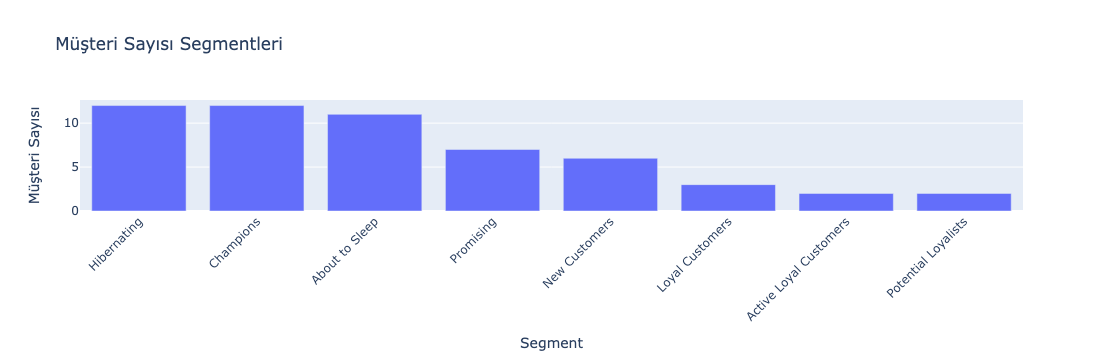

In [353]:
#Her segmentte kaçar kişi olduğunu görelim?
import plotly.express as px

# Segmentlere göre müşteri sayısını hesapla
segment_counts = final_df['segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Customer Count']

# Çubuk grafiğini çiz
fig = px.bar(segment_counts, x='Segment', y='Customer Count', 
             title='Müşteri Sayısı Segmentleri', 
             labels={'Segment': 'Segment', 'Customer Count': 'Müşteri Sayısı'})
fig.update_layout(xaxis_tickangle=-45)
fig.show()



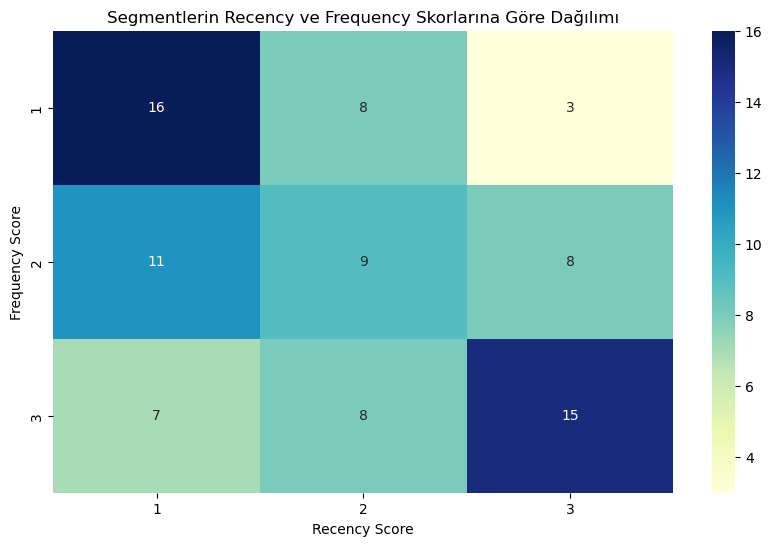

In [358]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Verileri görselleştirmek için uygun bir formata dönüştürme
final_df['RecencyScore'] = final_df['RecencyScore'].astype(int)
final_df['FrequencyScore'] = final_df['FrequencyScore'].astype(int)

# Frekans tablosunu oluşturma
frequency_table = final_df.groupby(['RecencyScore', 'FrequencyScore'])['segment'].size().unstack(fill_value=0)

# Heatmap oluşturma
plt.figure(figsize=(10, 6))
sns.heatmap(frequency_table, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Segmentlerin Recency ve Frequency Skorlarına Göre Dağılımı')
plt.xlabel('Recency Score')
plt.ylabel('Frequency Score')
plt.show()